# Assignment 1:  Sentiment with Deep Neural Networks

Welcome to the first assignment of course 3. In this assignment, you will explore sentiment analysis using deep neural networks. 
## Outline
- [Part 1:  Import libraries and try out Trax](#1)
- [Part 2:  Importing the data](#2)
    - [2.1  Loading in the data](#2.1)
    - [2.2  Building the vocabulary](#2.2)
    - [2.3  Converting a tweet to a tensor](#2.3)
        - [Exercise 01](#ex01)
    - [2.4  Creating a batch generator](#2.4)
        - [Exercise 02](#ex02)
- [Part 3:  Defining classes](#3)
    - [3.1  ReLU class](#3.1)
        - [Exercise 03](#ex03)
    - [3.2  Dense class ](#3.2)
        - [Exercise 04](#ex04)
    - [3.3  Model](#3.3)
        - [Exercise 05](#ex05)
- [Part 4:  Training](#4)
    - [4.1  Training the model](#4.1)
        - [Exercise 06](#ex06)
    - [4.2  Practice Making a prediction](#4.2)
- [Part 5:  Evaluation  ](#5)
    - [5.1  Computing the accuracy on a batch](#5.1)
        - [Exercise 07](#ex07)
    - [5.2  Testing your model on Validation Data](#5.2)
        - [Exercise 08](#ex08)
- [Part 6:  Testing with your own input](#6)
- [Part 7: Word Embeddings](#7)

In course 1, you implemented Logistic regression and Naive Bayes for sentiment analysis. However if you were to give your old models an example like:

<center> <span style='color:blue'> <b>This movie was almost good.</b> </span> </center>

Your model would have predicted a positive sentiment for that review. However, that sentence has a negative sentiment and indicates that the movie was not good. To solve those kinds of misclassifications, you will write a program that uses deep neural networks to identify sentiment in text. By completing this assignment, you will: 

- Understand how you can build/design a model using layers
- Train a model using a training loop
- Use a binary cross-entropy loss function
- Compute the accuracy of your model
- Predict using your own input

As you can tell, this model follows a similar structure to the one you previously implemented in the second course of this specialization. 
- Indeed most of the deep nets you will be implementing will have a similar structure. The only thing that changes is the model architecture, the inputs, and the outputs. Before starting the assignment, we will introduce you to the Google library `trax` that we use for building and training models.


Now we will show you how to compute the gradient of a certain function `f` by just using `  .grad(f)`. 

- Trax source code can be found on Github: [Trax](https://github.com/google/trax)
- The Trax code also uses the JAX library: [JAX](https://jax.readthedocs.io/en/latest/index.html)

<a name="1"></a>
# Part 1:  Import libraries and try out Trax

- Let's import libraries and look at an example of using the Trax library.

In [3]:
import os 
import shutil
import random as rnd

# import relevant libraries
import trax
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath

# import Layer from the utils.py file
from utils import Layer, load_tweets, process_tweet
import w1_unittest

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Create an array using trax.fastmath.numpy
a = np.array(5.0)

# View the returned array
display(a)

print(type(a))

DeviceArray(5., dtype=float32)

<class 'jaxlib.xla_extension.DeviceArray'>


Notice that trax.fastmath.numpy returns a DeviceArray from the jax library.

In [5]:
# Define a function that will use the trax.fastmath.numpy array
def f(x):
    
    # f = x^2
    return (x**2)

In [6]:
# Call the function
print(f"f(a) for a={a} is {f(a)}")

f(a) for a=5.0 is 25.0


The gradient (derivative) of function `f` with respect to its input `x` is the derivative of $x^2$.
- The derivative of $x^2$ is $2x$.  
- When x is 5, then $2x=10$.

You can calculate the gradient of a function by using `trax.fastmath.grad(fun=)` and passing in the name of the function.
- In this case the function you want to take the gradient of is `f`.
- The object returned (saved in `grad_f` in this example) is a function that can calculate the gradient of f for a given trax.fastmath.numpy array.

In [7]:
# Directly use trax.fastmath.grad to calculate the gradient (derivative) of the function
grad_f = trax.fastmath.grad(fun=f)  # df / dx - Gradient of function f(x) with respect to x

# View the type of the retuned object (it's a function)
type(grad_f)

function

In [8]:
# Call the newly created function and pass in a value for x (the DeviceArray stored in 'a')
grad_calculation = grad_f(a)

# View the result of calling the grad_f function
display(grad_calculation)

DeviceArray(10., dtype=float32)

The function returned by trax.fastmath.grad takes in x=5 and calculates the gradient of f, which is 2*x, which is 10. The value is also stored as a DeviceArray from the jax library.

<a name="2"></a>
# Part 2:  Importing the data

<a name="2.1"></a>
## 2.1  Loading in the data

Import the data set.  
- You may recognize this from earlier assignments in the specialization.
- Details of process_tweet function are available in utils.py file

In [9]:
## DO NOT EDIT THIS CELL

# Import functions from the utils.py file

def train_val_split():
    # Load positive and negative tweets
    all_positive_tweets, all_negative_tweets = load_tweets()

    # View the total number of positive and negative tweets.
    print(f"The number of positive tweets: {len(all_positive_tweets)}")
    print(f"The number of negative tweets: {len(all_negative_tweets)}")

    # Split positive set into validation and training
    val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
    train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

    # Split negative set into validation and training
    val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
    train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets
    
    # Combine training data into one set
    train_x = train_pos + train_neg 

    # Combine validation data into one set
    val_x  = val_pos + val_neg

    # Set the labels for the training set (1 for positive, 0 for negative)
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

    # Set the labels for the validation set (1 for positive, 0 for negative)
    val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))


    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

In [10]:
train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x 8000
length of val_x 2000


Now import a function that processes tweets (we've provided this in the utils.py file).
- `process_tweets` removes unwanted characters e.g. hashtag, hyperlinks, stock tickers from tweet.
- It also returns a list of words (it tokenizes the original string).

In [11]:
# Try out function that processes tweets
print("original tweet at training position 0")
print(train_pos[0])

print("Tweet at training position 0 after processing:")
process_tweet(train_pos[0])

original tweet at training position 0
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tweet at training position 0 after processing:


['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

Notice that the function `process_tweet` keeps key words, removes the hash # symbol, and ignores usernames (words that begin with '@').  It also returns a list of the words.

<a name="2.2"></a>
## 2.2  Building the vocabulary

Now build the vocabulary.
- Map each word in each tweet to an integer (an "index"). 
- The following code does this for you, but please read it and understand what it's doing.
- Note that you will build the vocabulary based on the training data. 
- To do so, you will assign an index to everyword by iterating over your training set.

The vocabulary will also include some special tokens
- `__PAD__`: padding
- `</e>`: end of line
- `__UNK__`: a token representing any word that is not in the vocabulary.

In [12]:
# Build the vocabulary
# Unit Test Note - There is no test set here only train/val
def get_vocab(train_x):

    # Include special tokens 
    # started with pad, end of line and unk tokens
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

    # Note that we build vocab using training data
    for tweet in train_x: 
        processed_tweet = process_tweet(tweet)
        for word in processed_tweet:
            if word not in Vocab: 
                Vocab[word] = len(Vocab)
    
    return Vocab

Vocab = get_vocab(train_x)

print("Total words in vocab are",len(Vocab))
display(Vocab)

Total words in vocab are 9088


{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'followfriday': 3,
 'top': 4,
 'engag': 5,
 'member': 6,
 'commun': 7,
 'week': 8,
 ':)': 9,
 'hey': 10,
 'jame': 11,
 'odd': 12,
 ':/': 13,
 'pleas': 14,
 'call': 15,
 'contact': 16,
 'centr': 17,
 '02392441234': 18,
 'abl': 19,
 'assist': 20,
 'mani': 21,
 'thank': 22,
 'listen': 23,
 'last': 24,
 'night': 25,
 'bleed': 26,
 'amaz': 27,
 'track': 28,
 'scotland': 29,
 'congrat': 30,
 'yeaaah': 31,
 'yipppi': 32,
 'accnt': 33,
 'verifi': 34,
 'rqst': 35,
 'succeed': 36,
 'got': 37,
 'blue': 38,
 'tick': 39,
 'mark': 40,
 'fb': 41,
 'profil': 42,
 '15': 43,
 'day': 44,
 'one': 45,
 'irresist': 46,
 'flipkartfashionfriday': 47,
 'like': 48,
 'keep': 49,
 'love': 50,
 'custom': 51,
 'wait': 52,
 'long': 53,
 'hope': 54,
 'enjoy': 55,
 'happi': 56,
 'friday': 57,
 'lwwf': 58,
 'second': 59,
 'thought': 60,
 '’': 61,
 'enough': 62,
 'time': 63,
 'dd': 64,
 'new': 65,
 'short': 66,
 'enter': 67,
 'system': 68,
 'sheep': 69,
 'must': 70,
 'buy':

The dictionary `Vocab` will look like this:
```CPP
{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'followfriday': 3,
 'top': 4,
 'engag': 5,
 ...
```

- Each unique word has a unique integer associated with it.
- The total number of words in Vocab: 9088

<a name="2.3"></a>
## 2.3  Converting a tweet to a tensor

Write a function that will convert each tweet to a tensor (a list of unique integer IDs representing the processed tweet).
- Note, the returned data type will be a **regular Python `list()`**
    - You won't use TensorFlow in this function
    - You also won't use a numpy array
    - You also won't use trax.fastmath.numpy array
- For words in the tweet that are not in the vocabulary, set them to the unique ID for the token `__UNK__`.

##### Example
Input a tweet:
```CPP
'@happypuppy, is Maria happy?'
```

The tweet_to_tensor will first conver the tweet into a list of tokens (including only relevant words)
```CPP
['maria', 'happi']
```

Then it will convert each word into its unique integer

```CPP
[2, 56]
```
- Notice that the word "maria" is not in the vocabulary, so it is assigned the unique integer associated with the `__UNK__` token, because it is considered "unknown."



<a name="ex01"></a>
### Exercise 01
**Instructions:** Write a program `tweet_to_tensor` that takes in a tweet and converts it to an array of numbers. You can use the `Vocab` dictionary you just found to help create the tensor. 

- Use the vocab_dict parameter and not a global variable.
- Do not hard code the integer value for the `__UNK__` token.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Map each word in tweet to corresponding token in 'Vocab'</li>
    <li>Use Python's Dictionary.get(key,value) so that the function returns a default value if the key is not found in the dictionary.</li>
</ul>
</p>


In [13]:
# CANDIDATE FOR TABLE TEST - If a student forgets to check for unk, there might be errors or just wrong values in the list.
# We can add those errors to check in autograder through tabled test or here student facing user test.

# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT) 
# GRADED FUNCTION: tweet_to_tensor
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        tweet - A string containing a tweet
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with
        
    '''     
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Process the tweet into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_tweet(tweet)
    
    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)
        
    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = [] 
    
    # Get the unique integer ID of the __UNK__ token
    # GRADING NOTE: require the use of the variable, don't give credit for hard coding `2` as the unkown ID    

    unk_ID = vocab_dict[unk_token]
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
        
    # for each word in the list:
    for word in word_l:
        
        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
    
        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID)
    ### END CODE HERE ###

    return tensor_l

In [14]:
print("Actual tweet is\n", val_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(val_pos[0], vocab_dict=Vocab))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1065, 136, 479, 2351, 745, 8148, 1123, 745, 53, 2, 2672, 791, 2, 2, 349, 601, 2, 3489, 1017, 597, 4559, 9, 1065, 157, 2, 2]


##### Expected output

```CPP
Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1065, 136, 479, 2351, 745, 8148, 1123, 745, 53, 2, 2672, 791, 2, 2, 349, 601, 2, 3489, 1017, 597, 4559, 9, 1065, 157, 2, 2]
```

In [15]:
# Test your function
w1_unittest.test_tweet_to_tensor(tweet_to_tensor, Vocab)

 All tests passed


<a name="2.4"></a>
## 2.4  Creating a batch generator

Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets. 
- If instead of training with batches of examples, you were to train a model with one example at a time, it would take a very long time to train the model. 
- You will now build a data generator that takes in the positive/negative tweets and returns a batch of training examples. It returns the model inputs, the targets (positive or negative labels) and the weight for each target (ex: this allows us to can treat some examples as more important to get right than others, but commonly this will all be 1.0). 

Once you create the generator, you could include it in a for loop

```CPP
for batch_inputs, batch_targets, batch_example_weights in data_generator:
    ...
```

You can also get a single batch like this:

```CPP
batch_inputs, batch_targets, batch_example_weights = next(data_generator)
```
The generator returns the next batch each time it's called. 
- This generator returns the data in a format (tensors) that you could directly use in your model.
- It returns a triplet: the inputs, targets, and loss weights:
    - Inputs is a tensor that contains the batch of tweets we put into the model.
    - Targets is the corresponding batch of labels that we train to generate.
    - Loss weights here are just 1s with same shape as targets. Next week, you will use it to mask input padding.

<a name="ex02"></a>
### Exercise 02
Implement `data_generator`.

In [16]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED: Data generator
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of positive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     

    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples    
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1


            
        ### START CODE HERE (Replace instances of 'None' with your code) ###

        # Second part: Pack n_to_take negative examples

        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset,
            if neg_index >= len_data_neg:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True 
                    break 
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
                    
            # get the tweet as neg_index
            tweet = data_neg[neg_index_lines[neg_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index = neg_index + 1

        ### END CODE HERE ###        

        if stop:
            break;

        # Update the start index for positive data 
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take
        
        # Update the start index for negative data 
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take
        
        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:


        ### START CODE HERE (Replace instances of 'None' with your code) ###
            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0] * n_pad
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)
  
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1] * n_to_take
        
        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg =  [0] * n_to_take
        
        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg
        
        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)
        

        ### END CODE HERE ###

        # note we use yield and not return
        yield inputs, targets, example_weights

Now you can use your data generator to create a data generator for the training data, and another data generator for the validation data.

We will create a third data generator that does not loop, for testing the final accuracy of the model.

In [17]:
# Set the random number generator for the shuffle procedure
rnd.seed(30) 

# Create the training data generator

def train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def test_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=False
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, train_pos, train_neg, Vocab, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4451 3201    9    0    0    0    0    0    0    0]
 [4954  567 2000 1454 5174 3499  141 3499  130  459    9]
 [3761  109  136  583 2930 3969    0    0    0    0    0]
 [ 250 3761    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [18]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4, train_pos=train_pos, train_neg=train_neg, vocab_dict=Vocab)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5738 2901 3761    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 858  256 3652 5739  307 4458  567 1230 2767  328 1202 3761    0    0]; target 0; example weights 1


##### Expected output

```CPP
The inputs shape is (4, 14)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5738 2901 3761    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 858  256 3652 5739  307 4458  567 1230 2767  328 1202 3761    0    0]; target 0; example weights 1
```

In [19]:
# Test your function
w1_unittest.test_data_generator(data_generator(data_pos=train_pos, data_neg=train_neg, batch_size=4, loop=True, vocab_dict=Vocab, shuffle = False))

 All tests passed


([], 11)

Now that you have your train/val generators, you can just call them and they will return tensors which correspond to your tweets in the first column and their corresponding labels in the second column. Now you can go ahead and start building your neural network. 

<a name="3"></a>
# Part 3:  Defining classes

In this part, you will write your own library of layers. It will be very similar
to the one used in Trax and also in Keras and PyTorch. Writing your own small
framework will help you understand how they all work and use them effectively
in the future.

Your framework will be based on the following `Layer` class from utils.py.

```CPP
class Layer(object):
    """ Base class for layers.
    """
      
    # Constructor
    def __init__(self):
        # set weights to None
        self.weights = None

    # The forward propagation should be implemented
    # by subclasses of this Layer class
    def forward(self, x):
        raise NotImplementedError

    # This function initializes the weights
    # based on the input signature and random key,
    # should be implemented by subclasses of this Layer class
    def init_weights_and_state(self, input_signature, random_key):
        pass

    # This initializes and returns the weights, do not override.
    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights
 
    # __call__ allows an object of this class
    # to be called like it's a function.
    def __call__(self, x):
        # When this layer object is called, 
        # it calls its forward propagation function
        return self.forward(x)
```

<a name="3.1"></a>
## 3.1  ReLU class
You will now implement the ReLU activation function in a class below. The ReLU function looks as follows: 
<img src = "images/relu.jpg" style="width:300px;height:150px;"/>

$$ \mathrm{ReLU}(x) = \mathrm{max}(0,x) $$


<a name="ex03"></a>
### Exercise 03
**Instructions:** Implement the ReLU activation function below. Your function should take in a matrix or vector and it should transform all the negative numbers into 0 while keeping all the positive numbers intact. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Please use numpy.maximum(A,k) to find the maximum between each element in A and a scalar k</li>
</ul>
</p>


In [20]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Relu
class Relu(Layer):
    """Relu activation function implementation"""
    def forward(self, x):
        '''
        Input: 
            - x (a numpy array): the input
        Output:
            - activation (numpy array): all positive or 0 version of x
        '''
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        
        activation = np.maximum(x, 0)

        ### END CODE HERE ###
        
        return activation

In [21]:
# Test your relu function
x = np.array([[-2.0, -1.0, 0.0], [0.0, 1.0, 2.0]], dtype=float)
relu_layer = Relu()
print("Test data is:")
print(x)
print("Output of Relu is:")
print(relu_layer(x))

Test data is:
[[-2. -1.  0.]
 [ 0.  1.  2.]]
Output of Relu is:
[[0. 0. 0.]
 [0. 1. 2.]]


##### Expected Outout
```CPP
Test data is:
[[-2. -1.  0.]
 [ 0.  1.  2.]]
Output of Relu is:
[[0. 0. 0.]
 [0. 1. 2.]]
```

In [22]:
# Test your function
w1_unittest.test_Relu(Relu)

 All tests passed


<a name="3.2"></a>
## 3.2  Dense class 

### Exercise

Implement the forward function of the Dense class. 
- The forward function multiplies the input to the layer (`x`) by the weight matrix (`W`)

$$\mathrm{forward}(\mathbf{x},\mathbf{W}) = \mathbf{xW} $$

- You can use `numpy.dot` to perform the matrix multiplication.

Note that for more efficient code execution, you will use the trax version of `math`, which includes a trax version of `numpy` and also `random`.

Implement the weight initializer `new_weights` function
- Weights are initialized with a random key.
- The second parameter is a tuple for the desired shape of the weights (num_rows, num_cols)
- The num of rows for weights should equal the number of columns in x, because for forward propagation, you will multiply x times weights.

Please use `trax.fastmath.random.normal(key, shape, dtype=tf.float32)` to generate random values for the weight matrix. The key difference between this function
and the standard `numpy` randomness is the explicit use of random keys, which
need to be passed. While it can look tedious at the first sight to pass the random key everywhere, you will learn in Course 4 why this is very helpful when
implementing some advanced models.
- `key` can be generated by calling `random.get_prng(seed=)` and passing in a number for the `seed`.
- `shape` is a tuple with the desired shape of the weight matrix.
    - The number of rows in the weight matrix should equal the number of columns in the variable `x`.  Since `x` may have 2 dimensions if it represents a single training example (row, col), or three dimensions (batch_size, row, col), get the last dimension from the tuple that holds the dimensions of x.
    - The number of columns in the weight matrix is the number of units chosen for that dense layer.  Look at the `__init__` function to see which variable stores the number of units.
- `dtype` is the data type of the values in the generated matrix; keep the default of `tf.float32`. In this case, don't explicitly set the dtype (just let it use the default value).

Set the standard deviation of the random values to 0.1
- The values generated have a mean of 0 and standard deviation of 1.
- Set the default standard deviation `stdev` to be 0.1 by multiplying the standard deviation to each of the values in the weight matrix.

In [23]:
# See how the trax.fastmath.random.normal function works
tmp_key = trax.fastmath.random.get_prng(seed=1)
print("The random seed generated by random.get_prng")
display(tmp_key)

print("choose a matrix with 2 rows and 3 columns")
tmp_shape=(2,3)
display(tmp_shape)

# Generate a weight matrix
# Note that you'll get an error if you try to set dtype to tf.float32, where tf is tensorflow
# Just avoid setting the dtype and allow it to use the default data type
tmp_weight = trax.fastmath.random.normal(key=tmp_key, shape=tmp_shape)

print("Weight matrix generated with a normal distribution with mean 0 and stdev of 1")
display(tmp_weight)

The random seed generated by random.get_prng


DeviceArray([0, 1], dtype=uint32)

choose a matrix with 2 rows and 3 columns


(2, 3)

Weight matrix generated with a normal distribution with mean 0 and stdev of 1


DeviceArray([[ 0.95730704, -0.96992904,  1.0070664 ],
             [ 0.36619025,  0.17294823,  0.29092228]], dtype=float32)

<a name="ex04"></a>
### Exercise 04

Implement the `Dense` class.

In [24]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Dense
class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """

    # __init__ is implemented for you
    def __init__(self, n_units, init_stdev=0.1):
        
        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Please implement 'forward()'
    def forward(self, x):        
        ### START CODE HERE (Replace instances of 'None' with your code) ###        
        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights)
        
        ### END CODE HERE ###
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution, 
        # and standard deviation of 'stdev'        
        w = self._init_stdev * trax.fastmath.random.normal(key = random_key, shape = (input_shape[1], self._n_units))
                
        ### END CODE HERE ###     
        self.weights = w
        return self.weights

In [25]:
# Testing your Dense layer 
dense_layer = Dense(n_units=10)  #sets  number of units in dense layer
random_key = trax.fastmath.random.get_prng(seed=0)  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.02837108  0.09368162 -0.10050076  0.14165013  0.10543301  0.09108126
  -0.04265672  0.0986188  -0.05575325  0.00153249]
 [-0.20785688  0.0554837   0.09142365  0.05744595  0.07227863  0.01210617
  -0.03237354  0.16234995  0.02450038 -0.13809784]
 [-0.06111237  0.01403724  0.08410042 -0.1094358  -0.10775021 -0.11396459
  -0.05933381 -0.01557652 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395496   0.9266802   2.5414743  -2.050473   -1.9769388  -2.582209
  -1.7952735   0.94427425 -0.8980402  -3.7497487 ]]


##### Expected Outout
```CPP
Weights are
  [[-0.02837108  0.09368162 -0.10050076  0.14165013  0.10543301  0.09108126
  -0.04265672  0.0986188  -0.05575325  0.00153249]
 [-0.20785688  0.0554837   0.09142365  0.05744595  0.07227863  0.01210617
  -0.03237354  0.16234995  0.02450038 -0.13809784]
 [-0.06111237  0.01403724  0.08410042 -0.1094358  -0.10775021 -0.11396459
  -0.05933381 -0.01557652 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395496   0.9266802   2.5414743  -2.050473   -1.9769388  -2.582209
  -1.7952735   0.94427425 -0.8980402  -3.7497487 ]]
```

In [26]:
# Testing your Dense layer 
dense_layer = Dense(n_units=5)  #sets  number of units in dense layer
random_key = trax.fastmath.random.get_prng(seed=0)  # sets random seed
z = np.array([[-1.0, 10.0, 0.0, 5.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[ 0.1054516  -0.09692889 -0.05946022 -0.00318858  0.24109319]
 [-0.18784496 -0.07847697 -0.03137085  0.03337088  0.17677031]
 [-0.10277648  0.14111717 -0.05084972 -0.05263776  0.05031503]
 [ 0.10549792 -0.00874074  0.07958166  0.2656559  -0.05822907]]
Foward function output is  [[-1.4564117  -0.73154444  0.14365998  1.6651769   1.2354646 ]]


In [27]:
# Test your function
w1_unittest.test_Dense(Dense)

 All tests passed


<a name="3.3"></a>
## 3.3  Model

Now you will implement a classifier using neural networks. Here is the model architecture you will be implementing. 

<img src = "images/nn.jpg" style="width:400px;height:250px;"/>

For the model implementation, you will use the Trax `layers` module, imported as `tl`.
Note that the second character of `tl` is the lowercase of letter `L`, not the number 1. Trax layers are very similar to the ones you implemented above,
but in addition to trainable weights also have a non-trainable state.
State is used in layers like batch normalization and for inference, you will learn more about it in course 4.

First, look at the code of the Trax Dense layer and compare to your implementation above.
- [tl.Dense](https://github.com/google/trax/blob/master/trax/layers/core.py#L29): Trax Dense layer implementation

One other important layer that you will use a lot is one that allows to execute one layer after another in sequence.
- [tl.Serial](https://github.com/google/trax/blob/master/trax/layers/combinators.py#L26): Combinator that applies layers serially.  
    - You can pass in the layers as arguments to `Serial`, separated by commas. 
    - For example: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))`

Please use the `help` function to view documentation for each layer.

In [28]:
# View documentation on tl.Dense
help(tl.Dense)

Help on class Dense in module trax.layers.core:

class Dense(trax.layers.base.Layer)
 |  Dense(n_units, kernel_initializer=<function ScaledInitializer.<locals>.Init at 0x7f00f0404170>, bias_initializer=<function RandomNormalInitializer.<locals>.<lambda> at 0x7f00f0404200>, use_bias=True, use_bfloat16=False)
 |  
 |  A dense (a.k.a. fully-connected, affine) layer.
 |  
 |  Dense layers are the prototypical example of a trainable layer, i.e., a layer
 |  with trainable weights. Each node in a dense layer computes a weighted sum of
 |  all node values from the preceding layer and adds to that sum a node-specific
 |  bias term. The full layer computation is expressed compactly in linear
 |  algebra as an affine map `y = Wx + b`, where `W` is a matrix and `y`, `x`,
 |  and `b` are vectors. The layer is trained, or "learns", by updating the
 |  values in `W` and `b`.
 |  
 |  Less commonly, a dense layer can omit the bias term and be a pure linear map:
 |  `y = Wx`.
 |  
 |  Method resolutio

In [29]:
# View documentation on tl.Serial
help(tl.Serial)

Help on class Serial in module trax.layers.combinators:

class Serial(trax.layers.base.Layer)
 |  Serial(*sublayers, name=None, sublayers_to_print=None)
 |  
 |  Combinator that applies layers serially (by function composition).
 |  
 |  This combinator is commonly used to construct deep networks, e.g., like this::
 |  
 |      mlp = tl.Serial(
 |        tl.Dense(128),
 |        tl.Relu(),
 |        tl.Dense(10),
 |      )
 |  
 |  A Serial combinator uses stack semantics to manage data for its sublayers.
 |  Each sublayer sees only the inputs it needs and returns only the outputs it
 |  has generated. The sublayers interact via the data stack. For instance, a
 |  sublayer k, following sublayer j, gets called with the data stack in the
 |  state left after layer j has applied. The Serial combinator then:
 |  
 |    - takes n_in items off the top of the stack (n_in = k.n_in) and calls
 |      layer k, passing those items as arguments; and
 |  
 |    - takes layer k's n_out return values

- [tl.Embedding](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L113): Layer constructor function for an embedding layer.  
    - `tl.Embedding(vocab_size, d_feature)`.
    - `vocab_size` is the number of unique words in the given vocabulary.
    - `d_feature` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).    

In [30]:
# View documentation for tl.Embedding
help(tl.Embedding)

Help on class Embedding in module trax.layers.core:

class Embedding(trax.layers.base.Layer)
 |  Embedding(vocab_size, d_feature, use_bfloat16=False, kernel_initializer=<function ScaledInitializer.<locals>.Init at 0x7f00f0404560>)
 |  
 |  Trainable layer that maps discrete tokens/IDs to vectors.
 |  
 |  Embedding layers are commonly used to map discrete data, like words in NLP,
 |  into vectors. Here is a canonical example::
 |  
 |      vocab_size = 5
 |      word_ids = np.array([1, 2, 3, 4], dtype=np.int32)  # word_ids < vocab_size
 |      embedding_layer = tl.Embedding(vocab_size, 32)
 |      embedding_layer.init(trax.shapes.signature(word_ids))
 |      embedded = embedding_layer(word_ids)  # embedded.shape = (4, 32)
 |  
 |  Method resolution order:
 |      Embedding
 |      trax.layers.base.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, vocab_size, d_feature, use_bfloat16=False, kernel_initializer=<function ScaledInitializer.<locals>.Init at

In [31]:
# An example of and embedding layer
rnd.seed(31)
tmp_embed = tl.Embedding(d_feature=2, vocab_size=3)
display(tmp_embed)

Embedding_3_2

In [32]:
# Let's assume as an example, a batch of two lists
# each list represents a set of tokenized words.
tmp_in_arr = np.array([[0,1,2],
                    [3,2,0]
                   ])

# In order to use the layer, we need to initialize its signature
tmp_embed.init(trax.shapes.signature(tmp_in_arr))

# Embedding layer will return an array of shape (batch size, vocab size, d_feature)
tmp_embedded_arr = tmp_embed(tmp_in_arr)

print(f"Shape of returned array is {tmp_embedded_arr.shape}")
display(tmp_embedded_arr)

Shape of returned array is (2, 3, 2)


DeviceArray([[[-0.09254155,  1.1765094 ],
              [ 1.0511576 ,  0.7154667 ],
              [ 0.7439485 , -0.81590366]],

             [[ 0.7439485 , -0.81590366],
              [ 0.7439485 , -0.81590366],
              [-0.09254155,  1.1765094 ]]], dtype=float32)

- [tl.Mean](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L276): Calculates means across an axis.  In this case, please choose axis = 1 to get an average embedding vector (an embedding vector that is an average of all words in the vocabulary).  
- For example, if the embedding matrix is 300 elements and vocab size is 10,000 words, taking the mean of the embedding matrix along axis=1 will yield a vector of 300 elements.

In [33]:
# view the documentation for tl.mean
help(tl.Mean)

Help on function Mean in module trax.layers.core:

Mean(axis=-1, keepdims=False)
    Returns a layer that computes mean values using one tensor axis.
    
    `Mean` uses one tensor axis to form groups of values and replaces each group
    with the mean value of that group. The resulting values can either remain
    in their own size 1 axis (`keepdims=True`), or that axis can be removed from
    the overall tensor (default `keepdims=False`), lowering the rank of the
    tensor by one.
    
    Args:
      axis: Axis along which values are grouped for computing a mean.
      keepdims: If `True`, keep the resulting size 1 axis as a separate tensor
          axis; else, remove that axis.



In [34]:
# Pretend the embedding matrix uses 
# 2 elements for embedding the meaning of a word
# and has a vocabulary size of 3
# So it has shape (2,3)
tmp_embed = np.array([[1,2,3,],
                    [4,5,6]
                   ])

# take the mean along axis 0
print("The mean along axis 0 creates a vector whose length equals the vocabulary size")
display(np.mean(tmp_embed,axis=0))

print("The mean along axis 1 creates a vector whose length equals the number of elements in a word embedding")
display(np.mean(tmp_embed,axis=1))

The mean along axis 0 creates a vector whose length equals the vocabulary size


DeviceArray([2.5, 3.5, 4.5], dtype=float32)

The mean along axis 1 creates a vector whose length equals the number of elements in a word embedding


DeviceArray([2., 5.], dtype=float32)

- [tl.LogSoftmax](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L242): Implements log softmax function
- Here, you don't need to set any parameters for `LogSoftMax()`.

In [35]:
help(tl.LogSoftmax)

Help on function LogSoftmax in module trax.layers.core:

LogSoftmax(axis=-1)
    Returns a layer that applies log softmax along one tensor axis.
    
    Note that the implementation actually computes x - LogSumExp(x),
    which is mathematically equal to LogSoftmax(x).
    
    `LogSoftmax` acts on a group of values and normalizes them to look like a set
    of log probability values. (Probability values must be non-negative, and as
    a set must sum to 1. A group of log probability values can be seen as the
    natural logarithm function applied to a set of probability values.)
    
    Args:
      axis: Axis along which values are grouped for computing log softmax.



**Online documentation**

- [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense)

- [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#module-trax.layers.combinators)

- [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding)

- [tl.Mean](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Mean)

- [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax)

<a name="ex05"></a>
### Exercise 05
Implement the classifier function. 

In [54]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: classifier

def classifier(vocab_size=9088, embedding_dim=256, output_dim=2, mode='train'):
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
        
    # create embedding layer
    embed_layer = tl.Embedding( 
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim # Embedding dimension
    ) 
    
    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)
    
    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)
    
    # Create the log softmax layer (no parameters needed)
    log_softmax_layer = tl.LogSoftmax()
    
    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial( 
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer, # dense output layer
      log_softmax_layer # log softmax layer
    ) 
    ### END CODE HERE ###
    
    # return the model of type
    return model

In [55]:
tmp_model = classifier(vocab_size=len(Vocab))

In [56]:
print(type(tmp_model))
display(tmp_model)

<class 'trax.layers.combinators.Serial'>


Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]

##### Expected Outout
```python
<class 'trax.layers.combinators.Serial'>
Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]
```

In [57]:
# Test your function
w1_unittest.test_classifier(classifier)

 All tests passed


<a name="4"></a>
# Part 4:  Training

To train a model on a task, Trax defines an abstraction [`trax.supervised.training.TrainTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) which packages the train data, loss and optimizer (among other things) together into an object.

Similarly to evaluate a model, Trax defines an abstraction [`trax.supervised.training.EvalTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) which packages the eval data and metrics (among other things) into another object.

The final piece tying things together is the [`trax.supervised.training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) abstraction that is a very simple and flexible way to put everything together and train the model, all the while evaluating it and saving checkpoints.
Using `Loop` will save you a lot of code compared to always writing the training loop by hand, like you did in courses 1 and 2. More importantly, you are less likely to have a bug in that code that would ruin your training.

In [58]:
# View documentation for trax.supervised.training.TrainTask
help(trax.supervised.training.TrainTask)

Help on class TrainTask in module trax.supervised.training:

class TrainTask(builtins.object)
 |  TrainTask(labeled_data, loss_layer, optimizer, lr_schedule=None, n_steps_per_checkpoint=100, n_steps_per_permanent_checkpoint=None, loss_name=None, sample_batch=None, export_prefix=None)
 |  
 |  A supervised task (labeled data + feedback mechanism) for training.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, labeled_data, loss_layer, optimizer, lr_schedule=None, n_steps_per_checkpoint=100, n_steps_per_permanent_checkpoint=None, loss_name=None, sample_batch=None, export_prefix=None)
 |      Configures a training task.
 |      
 |      Args:
 |        labeled_data: Iterator of batches of labeled data tuples. Each tuple has
 |            1+ data (input value) tensors followed by 1 label (target value)
 |            tensor.  All tensors are NumPy ndarrays or their JAX counterparts.
 |        loss_layer: Layer that computes a scalar value (the "loss") by comparing
 |            model o

In [59]:
# View documentation for trax.supervised.training.EvalTask
help(trax.supervised.training.EvalTask)

Help on class EvalTask in module trax.supervised.training:

class EvalTask(builtins.object)
 |  EvalTask(labeled_data, metrics, metric_names=None, n_eval_batches=1, sample_batch=None, export_prefix=None)
 |  
 |  Labeled data plus scalar functions for (periodically) measuring a model.
 |  
 |  An eval task specifies how (``labeled_data`` + ``metrics``) and with what
 |  precision (``n_eval_batches``) to measure a model as it is training.
 |  The variance of each scalar output is reduced by measuring over multiple
 |  (``n_eval_batches``) batches and reporting the average from those
 |  measurements.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, labeled_data, metrics, metric_names=None, n_eval_batches=1, sample_batch=None, export_prefix=None)
 |      Configures an eval task: named metrics run with a given data source.
 |      
 |      Args:
 |        labeled_data: Iterator of batches of labeled data tuples. Each tuple has
 |            1+ data tensors (NumPy ndarrays) followed 

In [60]:
# View documentation for trax.supervised.training.Loop
help(trax.supervised.training.Loop)

Help on class Loop in module trax.supervised.training:

class Loop(builtins.object)
 |  Loop(model, tasks, eval_model=None, eval_tasks=None, output_dir=None, checkpoint_at=None, checkpoint_low_metric=None, checkpoint_high_metric=None, permanent_checkpoint_at=None, eval_at=None, which_task=None, n_devices=None, random_seed=None, loss_chunk_size=0, use_memory_efficient_trainer=False, adasum=False, callbacks=None)
 |  
 |  Loop that can run for a given number of steps to train a supervised model.
 |  
 |  Can train the model on multiple tasks by interleaving updates according to the
 |  ``which_task`` argument.
 |  
 |  The typical supervised training process randomly initializes a model and
 |  updates its weights via feedback (loss-derived gradients) from a training
 |  task, by looping through batches of labeled data. A training loop can also
 |  be configured to run periodic evals and save intermediate checkpoints.
 |  
 |  For speed, the implementation takes advantage of JAX's compos

In [61]:
# View optimizers that you could choose from
help(trax.optimizers)

Help on package trax.optimizers in trax:

NAME
    trax.optimizers - Optimizers for use with Trax layers.

PACKAGE CONTENTS
    adafactor
    adam
    base
    momentum
    optimizers_test
    rms_prop
    sm3
    trainer
    trainer_test

FUNCTIONS
    opt_configure(*args, **kwargs)

FILE
    /opt/conda/lib/python3.7/site-packages/trax/optimizers/__init__.py




Notice some available optimizers include:
```CPP
    adafactor
    adam
    momentum
    rms_prop
    sm3
```

<a name="4.1"></a>
## 4.1  Training the model

Now you are going to train your model. 

Let's define the `TrainTask`, `EvalTask` and `Loop` in preparation to train the model.

In [62]:
# PLEASE, DO NOT MODIFY OR DELETE THIS CELL
from trax.supervised import training

def get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, vocab_dict, loop, batch_size = 16):
    
    rnd.seed(271)

    train_task = training.TrainTask(
        labeled_data=train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop
                    , shuffle = True),
        loss_layer=tl.CrossEntropyLoss(),
        optimizer=trax.optimizers.Adam(0.01),
        n_steps_per_checkpoint=10,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop
                    , shuffle = True),        
        metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
    )
    
    return train_task, eval_task
    

train_task, eval_task = get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, Vocab, True, batch_size = 16)
model = classifier()

In [63]:
model

Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]

This defines a model trained using [`tl.CrossEntropyLoss`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss) optimized with the [`trax.optimizers.Adam`](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html#trax.optimizers.adam.Adam) optimizer, all the while tracking the accuracy using [`tl.Accuracy`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.Accuracy) metric. We also track `tl.CrossEntropyLoss` on the validation set.

Now let's make an output directory and train the model.

In [64]:
dir_path = './model/'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    pass


output_dir = './model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

./model/


<a name="ex06"></a>
### Exercise 06
**Instructions:** Implement `train_model` to train the model (`classifier` that you wrote earlier) for the given number of training steps (`n_steps`) using `TrainTask`, `EvalTask` and `Loop`. For the `EvalTask`, take a look to the cell next to the function definition: the `eval_task` is passed as a list explicitly, so take that into account in the implementation of your `train_model` function.

In [65]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: train_model
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task. Received as a list
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    rnd.seed(31) # Do NOT modify this random seed. This makes the notebook easier to replicate
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###          
    training_loop = training.Loop( 
                                classifier, # The learning model
                                train_task, # The training task
                                eval_tasks=eval_task, # The evaluation task
                                output_dir=output_dir, # The output directory
                                random_seed=31 # Do not modify this random seed in order to ensure reproducibility and for grading purposes.
    ) 

    training_loop.run(n_steps = n_steps)
    ### END CODE HERE ###
    
    # Return the training_loop, since it has the model.
    return training_loop

In [66]:
# Do not modify this cell.
# Take a look on how the eval_task is inside square brackets and 
# take that into account for you train_model implementation
training_loop = train_model(model, train_task, [eval_task], 100, output_dir_expand)


Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 1.73 secs
Step      1: train CrossEntropyLoss |  0.70209986
Step      1: eval  CrossEntropyLoss |  0.69093817
Step      1: eval          Accuracy |  0.50000000

Step     10: Ran 9 train steps in 5.75 secs
Step     10: train CrossEntropyLoss |  0.64466679
Step     10: eval  CrossEntropyLoss |  0.58805430
Step     10: eval          Accuracy |  0.68750000

Step     20: Ran 10 train steps in 3.65 secs
Step     20: train CrossEntropyLoss |  0.44335634
Step     20: eval  CrossEntropyLoss |  0.27997807
Step     20: eval          Accuracy |  1.00000000

Step     30: Ran 10 train steps in 2.51 secs
Step     30: train CrossEntropyLoss |  0.22508216
Step     30: eval  CrossEntropyLoss |  0.14100222
Step     30: eval          Accuracy |  1.00000000

Step     40: Ran 10 train steps in 1.64 secs
Step     40: train CrossEntropyLoss |  0.14901149
Step     40: eval  CrossEntropyLoss |  0.10110895
Step     40: eva

##### Expected output (Approximately)

```python
Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 1.54 secs
Step      1: train CrossEntropyLoss |  0.70209986
Step      1: eval  CrossEntropyLoss |  0.69093817
Step      1: eval          Accuracy |  0.50000000

Step     10: Ran 9 train steps in 6.05 secs
Step     10: train CrossEntropyLoss |  0.64466673
Step     10: eval  CrossEntropyLoss |  0.58805430
Step     10: eval          Accuracy |  0.68750000

Step     20: Ran 10 train steps in 3.30 secs
Step     20: train CrossEntropyLoss |  0.44335628
Step     20: eval  CrossEntropyLoss |  0.27997801
Step     20: eval          Accuracy |  1.00000000

Step     30: Ran 10 train steps in 2.26 secs
Step     30: train CrossEntropyLoss |  0.22508219
Step     30: eval  CrossEntropyLoss |  0.14100222
Step     30: eval          Accuracy |  1.00000000

Step     40: Ran 10 train steps in 1.38 secs
Step     40: train CrossEntropyLoss |  0.14901149
Step     40: eval  CrossEntropyLoss |  0.10110895
Step     40: eval          Accuracy |  1.00000000

Step     50: Ran 10 train steps in 0.62 secs
Step     50: train CrossEntropyLoss |  0.05420516
Step     50: eval  CrossEntropyLoss |  0.12490455
Step     50: eval          Accuracy |  0.93750000

Step     60: Ran 10 train steps in 1.45 secs
Step     60: train CrossEntropyLoss |  0.06734458
Step     60: eval  CrossEntropyLoss |  0.02766964
Step     60: eval          Accuracy |  1.00000000

Step     70: Ran 10 train steps in 0.65 secs
Step     70: train CrossEntropyLoss |  0.04793770
Step     70: eval  CrossEntropyLoss |  0.00749207
Step     70: eval          Accuracy |  1.00000000

Step     80: Ran 10 train steps in 0.63 secs
Step     80: train CrossEntropyLoss |  0.05345479
Step     80: eval  CrossEntropyLoss |  0.00269653
Step     80: eval          Accuracy |  1.00000000

Step     90: Ran 10 train steps in 0.67 secs
Step     90: train CrossEntropyLoss |  0.02795754
Step     90: eval  CrossEntropyLoss |  0.00071710
Step     90: eval          Accuracy |  1.00000000

Step    100: Ran 10 train steps in 0.64 secs
Step    100: train CrossEntropyLoss |  0.01122378
Step    100: eval  CrossEntropyLoss |  0.00007641
Step    100: eval          Accuracy |  1.00000000
```

In [67]:
# Test your function. Do not modify this cell.
# Take a look on how the eval_task is inside square brackets.
try:
    shutil.rmtree('./model_test/')
except OSError as e:
    pass

w1_unittest.test_train_model(train_model(classifier(), train_task, [eval_task], 10, './model_test/'))


Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 1.57 secs
Step      1: train CrossEntropyLoss |  0.70368373
Step      1: eval  CrossEntropyLoss |  0.69825441
Step      1: eval          Accuracy |  0.56250000

Step     10: Ran 9 train steps in 5.93 secs
Step     10: train CrossEntropyLoss |  0.65071505
Step     10: eval  CrossEntropyLoss |  0.68158495
Step     10: eval          Accuracy |  0.50000000
 All tests passed


<a name="4.2"></a>
## 4.2  Practice Making a prediction

Now that you have trained a model, you can access it as `training_loop.model` object. We will actually use `training_loop.eval_model` and in the next weeks you will learn why we sometimes use a different model for evaluation, e.g., one without dropout. For now, make predictions with your model.

Use the training data just to see how the prediction process works.  
- Later, you will use validation data to evaluate your model's performance.


In [68]:
# Create a generator object
tmp_train_generator = train_generator(16, train_pos
                    , train_neg, Vocab, loop=True
                    , shuffle = False)



# get one batch
tmp_batch = next(tmp_train_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

print(f"The batch is a tuple of length {len(tmp_batch)} because position 0 contains the tweets, and position 1 contains the targets.") 
print(f"The shape of the tweet tensors is {tmp_inputs.shape} (num of examples, length of tweet tensors)")
print(f"The shape of the labels is {tmp_targets.shape}, which is the batch size.")
print(f"The shape of the example_weights is {tmp_example_weights.shape}, which is the same as inputs/targets size.")

The batch is a tuple of length 3 because position 0 contains the tweets, and position 1 contains the targets.
The shape of the tweet tensors is (16, 15) (num of examples, length of tweet tensors)
The shape of the labels is (16,), which is the batch size.
The shape of the example_weights is (16,), which is the same as inputs/targets size.


In [69]:
# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
print(f"The prediction shape is {tmp_pred.shape}, num of tensor_tweets as rows")
print("Column 0 is the probability of a negative sentiment (class 0)")
print("Column 1 is the probability of a positive sentiment (class 1)")
print()
print("View the prediction array")
tmp_pred

The prediction shape is (16, 2), num of tensor_tweets as rows
Column 0 is the probability of a negative sentiment (class 0)
Column 1 is the probability of a positive sentiment (class 1)

View the prediction array


DeviceArray([[-8.5139580e+00, -2.0074844e-04],
             [-9.5010920e+00, -7.4863434e-05],
             [-8.7240009e+00, -1.6260147e-04],
             [-8.6268597e+00, -1.7929077e-04],
             [-5.9606314e+00, -2.5815964e-03],
             [-7.9230204e+00, -3.6239624e-04],
             [-8.9105968e+00, -1.3494492e-04],
             [-4.4696903e+00, -1.1516809e-02],
             [-2.8090477e-03, -5.8762808e+00],
             [-2.0508766e-03, -6.1905422e+00],
             [-4.6277046e-04, -7.6783605e+00],
             [-4.7683716e-07, -1.4718504e+01],
             [-1.0578871e-02, -4.5541697e+00],
             [-1.4889240e-03, -6.5104399e+00],
             [-2.6021004e-03, -5.9527731e+00],
             [-7.6317787e-04, -7.1784296e+00]], dtype=float32)

To turn these probabilities into categories (negative or positive sentiment prediction), for each row:
- Compare the probabilities in each column.
- If column 1 has a value greater than column 0, classify that as a positive tweet.
- Otherwise if column 1 is less than or equal to column 0, classify that example as a negative tweet.

In [70]:
# turn probabilites into category predictions
tmp_is_positive = tmp_pred[:,1] > tmp_pred[:,0]
for i, p in enumerate(tmp_is_positive):
    print(f"Neg log prob {tmp_pred[i,0]:.4f}\tPos log prob {tmp_pred[i,1]:.4f}\t is positive? {p}\t actual {tmp_targets[i]}")

Neg log prob -8.5140	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -9.5011	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -8.7240	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -8.6269	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -5.9606	Pos log prob -0.0026	 is positive? True	 actual 1
Neg log prob -7.9230	Pos log prob -0.0004	 is positive? True	 actual 1
Neg log prob -8.9106	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -4.4697	Pos log prob -0.0115	 is positive? True	 actual 1
Neg log prob -0.0028	Pos log prob -5.8763	 is positive? False	 actual 0
Neg log prob -0.0021	Pos log prob -6.1905	 is positive? False	 actual 0
Neg log prob -0.0005	Pos log prob -7.6784	 is positive? False	 actual 0
Neg log prob -0.0000	Pos log prob -14.7185	 is positive? False	 actual 0
Neg log prob -0.0106	Pos log prob -4.5542	 is positive? False	 actual 0
Neg log prob -0.0015	Pos log prob -6.5104	 is positive? False	 actual 0

Notice that since you are making a prediction using a training batch, it's more likely that the model's predictions match the actual targets (labels).  
- Every prediction that the tweet is positive is also matching the actual target of 1 (positive sentiment).
- Similarly, all predictions that the sentiment is not positive matches the actual target of 0 (negative sentiment)

One more useful thing to know is how to compare if the prediction is matching the actual target (label).  
- The result of calculation `is_positive` is a boolean.
- The target is a type trax.fastmath.numpy.int32
- If you expect to be doing division, you may prefer to work with decimal numbers with the data type type trax.fastmath.numpy.int32

In [71]:
# View the array of booleans
print("Array of booleans")
display(tmp_is_positive)

# convert boolean to type int32
# True is converted to 1
# False is converted to 0
tmp_is_positive_int = tmp_is_positive.astype(np.int32)


# View the array of integers
print("Array of integers")
display(tmp_is_positive_int)

# convert boolean to type float32
tmp_is_positive_float = tmp_is_positive.astype(np.float32)

# View the array of floats
print("Array of floats")
display(tmp_is_positive_float)

Array of booleans


DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
             False, False, False, False, False, False, False, False],            dtype=bool)

Array of integers


DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Array of floats


DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
             0.], dtype=float32)

Note that Python usually does type conversion for you when you compare a boolean to an integer
- True compared to 1 is True, otherwise any other integer is False.
- False compared to 0 is True, otherwise any ohter integer is False.

In [72]:
print(f"True == 1: {True == 1}")
print(f"True == 2: {True == 2}")
print(f"False == 0: {False == 0}")
print(f"False == 2: {False == 2}")

True == 1: True
True == 2: False
False == 0: True
False == 2: False


However, we recommend that you keep track of the data type of your variables to avoid unexpected outcomes.  So it helps to convert the booleans into integers
- Compare 1 to 1 rather than comparing True to 1.

Hopefully you are now familiar with what kinds of inputs and outputs the model uses when making a prediction.
- This will help you implement a function that estimates the accuracy of the model's predictions.

<a name="5"></a>
# Part 5:  Evaluation  

<a name="5.1"></a>
## 5.1  Computing the accuracy on a batch

You will now write a function that evaluates your model on the validation set and returns the accuracy. 
- `preds` contains the predictions.
    - Its dimensions are `(batch_size, output_dim)`.  `output_dim` is two in this case.  Column 0 contains the probability that the tweet belongs to class 0 (negative sentiment). Column 1 contains probability that it belongs to class 1 (positive sentiment).
    - If the probability in column 1 is greater than the probability in column 0, then interpret this as the model's prediction that the example has label 1 (positive sentiment).  
    - Otherwise, if the probabilities are equal or the probability in column 0 is higher, the model's prediction is 0 (negative sentiment).
- `y` contains the actual labels.
- `y_weights` contains the weights to give to predictions.

<a name="ex07"></a>
### Exercise 07
Implement `compute_accuracy`.

In [73]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: compute_accuracy
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch,) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Create an array of booleans, 
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos = preds[:, 1] > preds[:, 0] 

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)
    
    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)
    
    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)
    
    # Multiply each prediction with its corresponding weight.
    weighted_correct_float =  correct_float * y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = np.sum(weighted_correct_float)
    
    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct/sum_weights

    ### END CODE HERE ###
    return accuracy, weighted_num_correct, sum_weights

In [74]:
# test your function
tmp_val_generator = val_generator(64, val_pos
                    , val_neg, Vocab, loop=True
                    , shuffle = False)

# get one batch
tmp_batch = next(tmp_val_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, y=tmp_targets, y_weights=tmp_example_weights)

print(f"Model's prediction accuracy on a single training batch is: {100 * tmp_acc}%")
print(f"Weighted number of correct predictions {tmp_num_correct}; weighted number of total observations predicted {tmp_num_predictions}")

Model's prediction accuracy on a single training batch is: 100.0%
Weighted number of correct predictions 64.0; weighted number of total observations predicted 64


##### Expected output (Approximately)

```
Model's prediction accuracy on a single training batch is: 100.0%
Weighted number of correct predictions 64.0; weighted number of total observations predicted 64
```

In [75]:
# Test your function
w1_unittest.test_compute_accuracy(compute_accuracy)

 All tests passed


<a name="5.2"></a>
## 5.2  Testing your model on Validation Data

Now you will write test your model's prediction accuracy on validation data. 

This program will take in a data generator and your model. 
- The generator allows you to get batches of data. You can use it with a `for` loop:

```
for batch in iterator: 
   # do something with that batch
```

`batch` has dimensions `(batch size, 2)`. 
- Column 0 corresponds to the tweet as a tensor.
- Column 1 corresponds to its target (actual label, positive or negative sentiment).
- You can feed the tweet into model and it will return the predictions for the batch. 


<a name="ex08"></a>
### Exercise 08

**Instructions:** 
- Compute the accuracy over all the batches in the validation iterator. 
- Make use of `compute_accuracy`, which you recently implemented, and return the overall accuracy.

In [76]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: test_model
def test_model(generator, model, compute_accuracy=compute_accuracy):
    '''
    Input: 
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance 
    Output: 
        accuracy: float corresponding to the accuracy
    '''
    
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
        
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    for batch in generator: 
        
        # Retrieve the inputs from the batch
        inputs = batch[0]
        
        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]
        
        # Retrieve the example weight.
        example_weight = batch[2]

        # Make predictions using the inputs            
        pred = model(inputs)
        
        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)
                
        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct
        
        # Update the total number of predictions 
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct / total_num_pred
    
    ### END CODE HERE ###
    return accuracy

In [77]:
# DO NOT EDIT THIS CELL
# testing the accuracy of your model: this takes around 20 seconds
model = training_loop.eval_model
accuracy = test_model(test_generator(16, val_pos
                    , val_neg, Vocab, loop=False
                    , shuffle = False), model)

print(f'The accuracy of your model on the validation set is {accuracy:.4f}', )

The accuracy of your model on the validation set is 0.9950


##### Expected Output (Approximately)

```CPP
The accuracy of your model on the validation set is 0.9950
```

In [78]:
# Test your function
w1_unittest.unittest_test_model(test_model, test_generator(16, val_pos , val_neg, Vocab, loop=False, shuffle = False), model)

 All tests passed


<a name="6"></a>
# Part 6:  Testing with your own input

Finally you will test with your own input. You will see that deepnets are more powerful than the older methods you have used before. Although you go close to 100% accuracy on the first two assignments, the task was way easier. 

In [79]:
# this is used to predict on your own sentnece
def predict(sentence):
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))
    
    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]  
    
    # predict with the model
    preds_probs = model(inputs)
    
    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    
    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment


In [80]:
# try a positive sentence
sentence = "It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

print()
# try a negative sentence
sentence = "I hated my day, it was the worst, I'm so sad."
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
***
is positive.

The sentiment of the sentence 
***
"I hated my day, it was the worst, I'm so sad."
***
is negative.


Notice that the model works well even for complex sentences.

<a name="7"></a>
# Part 7: Word Embeddings

In this section, you will visualize the word embeddings that were constructed for this sentiment analysis task. You can retrieve them by looking at the `model.weights` tuple (recall that the first layer of the model is the embedding layer).

In [81]:
embeddings = model.weights[0]

Let's take a look at the size of the embeddings. 

In [82]:
embeddings.shape

(9088, 256)

To visualize the word embeddings, it is necessary to choose 2 directions to use as axes for the plot. You could use random directions or the first two eigenvectors from PCA. Here, you'll use scikit-learn to perform dimensionality reduction of the word embeddings using PCA. 

In [83]:
from sklearn.decomposition import PCA #Import PCA from scikit-learn
pca = PCA(n_components=2) #PCA with two dimensions

emb_2dim = pca.fit_transform(embeddings) #Dimensionality reduction of the word embeddings

Now, everything is ready to plot a selection of words in 2d. 

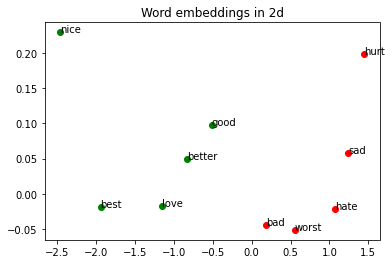

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

#Selection of negative and positive words
neg_words = ['worst', 'bad', 'hurt', 'sad', 'hate']
pos_words = ['best', 'good', 'nice', 'better', 'love']

#Index of each selected word
neg_n = [Vocab[w] for w in neg_words]
pos_n = [Vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(emb_2dim[neg_n][:,0],emb_2dim[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (emb_2dim[neg_n][i,0],emb_2dim[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(emb_2dim[pos_n][:,0],emb_2dim[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(emb_2dim[pos_n][i,0],emb_2dim[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()

As you can see, the word embeddings for this task seem to distinguish negative and positive meanings very well. However, clusters don't necessarily have similar words since you only trained the model to analyze overall sentiment. 

### On Deep Nets

Deep nets allow you to understand and capture dependencies that you would have not been able to capture with a simple linear regression, or logistic regression. 
- It also allows you to better use pre-trained embeddings for classification and tends to generalize better.